In [27]:
import torch 
import matplotlib.pyplot as plt 
import numpy as np
from bindsnet.network import Network
from bindsnet.network.nodes import Input, LIFNodes, AdaptiveLIFNodes
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor
from bindsnet.analysis.plotting import plot_spikes, plot_voltages, plot_weights
from bindsnet.learning import PostPre
from bindsnet.analysis.visualization import summary, plot_spike_trains_for_example, plot_voltage
from bindsnet import encoding

In [5]:
#define the helper's function

def loss_output(y,a_out):
    '''
    calculate the objective/Loss function
    at the last layer
    output : Loss tensor
    :param y (tensor): target label : 
    :param a_out (tensor): spike activity at the output layer
    '''
    o_de = 1 if (torch.max(torch.sum(a_out,dim=0))==0) else torch.max(torch.sum(a_out,dim=0))
    #o = torch.sum(a_out,dim=0) / torch.max(torch.sum(a_out,dim=0))    
    o = torch.sum(a_out,dim=0) / o_de   
    Loss = 0.5 * torch.pow(torch.norm(o - y),2)
    return Loss

def error_backprop_out(y,a_out):
    '''
    calculate the error at the output layer
    output : loss tensor
    param
    param
    '''
    o_de = 1 if (torch.max(torch.sum(a_out,dim=0))==0) else torch.max(torch.sum(a_out,dim=0))
    #o_vec = torch.sum(a_out,dim=0) / torch.max(torch.sum(a_out,dim=0))
    o_vec = torch.sum(a_out,dim=0) / o_de
    #denom = 1 if (np.sqrt(torch.count_nonzero(o_vec - y)) == 0) else np.sqrt(torch.count_nonzero(o_vec - y))
    denom = np.sqrt(torch.count_nonzero(o_vec - y))
    delta_Loss = (o_vec - y) / (denom +1)
    return delta_Loss


def error_backprop(net,a_hidden,a_out,deltai_nxt):
    '''
    calculate the backprop error for each layer except output layer
    output : the error backprop tensor with dimension 1 x Number of neurons in that layer
    :param : net, network object
    :input : input data
    :a_hidden : spike activity output at the hidden layer
    :a_out : spike activit output at the output/last layer
    :deltai_nxt : backprop error from the next layer
    '''
    w = list(net.parameters())
    wij = w[2]          #get the weight of the hidden layer
    Vth = net.layers["B"].thresh
    M = net.layers["B"].n#total synapses in the next layer
    m = torch.sum(a_out,dim=0).nonzero()#vector of active synapses in the next layer  
    n = torch.sum(a_hidden,dim=0).nonzero() #vector of active neuron in the next layer
    #n = 1 if (torch.sum(a_hidden,dim=0).nonzero()==0) else torch.sum(a_hidden,dim=0).nonzero()
    g_i   = 1 / Vth
    g_bar = np.sqrt((1/(1+len(n))) * torch.sum(torch.pow(g_i[n],2)))
    deltai = (g_i / g_bar) * np.sqrt(M/(1+len(m))) * (wij @ deltai_nxt)
    return deltai
    #return g_bar
    
def delta_weight(etaw,N,m,deltai,xj):
    '''
    calculate the delta weights in each layer
    output : the vector of weight of each layer
    input : etaw, learning rate
    input : N, total neuron in layer
    input : m, total of active synapses in layer
    input : deltai, vector of error backprop
    input : xj,vector of effective input spike activity
    '''
    di = torch.reshape(deltai,[1,len(deltai)])
    x_j = torch.sum(xj,dim=0)
    x_j = x_j.reshape([len(x_j),1])
    return -etaw * np.sqrt(N/(1+m)) * di * x_j

def delta_thrs(etath,N,m,M,deltai,ai):
    '''
    calculate the delta threshold in each neuron in layer
    output : the vector of voltage threshold of each layer
    input : etath, learning rate
    input : N, total neuron in layer
    input : m, total of active synapses in layer
    input : M, total synapses in the layer
    input : deltai, vector of error backprop
    input : xj,vector of effective output spike activity
    '''
    #di  = torch.reshape(deltai,[1,len(deltai)])
    #a_i = torch.sum(ai,dim=0)
    #a_i = a_i.reshape([len(a_i),1])
    return -etath * np.sqrt(N/((1+m)*M)) * deltai * torch.sum(ai,dim=0)


def update_params(net,etaw,etath,di_out,di_hid,a_out,a_hid,x_out,x_hid):
    '''torch.max(torch.sum(a_out,dim=0))
    calculate the delta weights and thresholds and update its value
    :input : net
    :
    '''
    N_out   = net.layers["C"].n#total neuron in the output layer
    N_hid   = net.layers["B"].n#total neuron in the hidden layer
    M_out   = N_hid #total synapses in the output layer
    M_hid   = net.layers["A"].n#total synapses in the hidden layer

    m_out   = len(torch.sum(a_out,dim=0).nonzero())#total active synapses in the output layer
    m_hid   = len(torch.sum(a_hidden,dim=0).nonzero())#total active synapses in the hidden layer

    w   = list(net.parameters())
    vth = [net.layers["B"].thresh,net.layers["C"].thresh]

    #1. weight in the last layer
    dwout = delta_weight(etaw,N_out,m_out,di_out,x_out)    
    w[2].add_(dwout) #update the parameters
    #2. weight in the middle layer
    dwhid = delta_weight(etaw,N_hid,m_hid,di_hid,x_hid)
    w[0].add_(dwhid) #update the parameters
    
    #3. threshold in the last layer
    d_thout = delta_thrs(etath,N_out,m_out,M_out,di_out,a_out)
    vth[1].add_(d_thout)
    #4. threshold in the middle layer
    d_thid = delta_thrs(etath,N_hid,m_hid,M_hid,di_hid,a_hid)
    vth[0].add_(d_thid)

    
    

In [79]:
#simulation time
time = 500 #in millisecond
batch = 8 #batch size
decay_time = 150 #wait till the membrane voltage to decay
#other parameters according Lee et.al(2016)
alpha = [8 ,3]
beta  = 10
lamda = 0.002
rho   = 0.0001
eta_w  = 0.0008        #learning rate for synaptic weight
eta_th = 0.1 * eta_w  #learning rate for voltage threshold
T_ref = 1               #refractory period
t_mp  = 100            #decay time
v_rest = -65          #default neuron rest voltage
v_thresh   = -52          #default neuron threshold voltage

#create the network
network = Network()
#create and add input, output layers

#voltage threshold as a vector 
# the value corresponds to every vth in each node
nodes = [20, 40, 4] #number of nodes in each layer

#initialize the voltage threshold
vth = [alpha[0]*np.sqrt(3.0/nodes[0]), alpha[1]*np.sqrt(3.0/nodes[1])]


thres1 = (v_rest+ vth[0]) + torch.zeros(1,nodes[1])
thres2 = (v_rest+vth[1]) + torch.zeros(1,nodes[2])

source_layer = Input(n=nodes[0],traces=True)
hidden_layer = LIFNodes(n=nodes[1],trace=True,refrac=T_ref,thresh=thres1.squeeze(),tc_decay=t_mp,lbound=v_rest - vth[0])
target_layer = LIFNodes(n=nodes[2],traces=True,refrac=T_ref,thresh=thres2.squeeze(),tc_decay=t_mp,lbound=v_rest - vth[1])
#target_layer = AdaptiveLIFNodes(n=4, traces=True,refrac=1,thresh=)

network.add_layer(
    layer = source_layer, name="A"
)
network.add_layer(
    layer = hidden_layer, name="B"
)
network.add_layer(
    layer = target_layer, name="C"
)

#print("voltage threshold in output layer neuron "+str(network.layers["C"].thresh))
#print("voltage threshold in hidden layer neuron "+str(network.layers["B"].thresh))
#create a connection between input and hidden layers
forward_connection1 = Connection(
    source = source_layer,
    target= hidden_layer,
    #weight initialization according to Lee et.al
    w = (np.sqrt(3.0/source_layer.n)) - 2*np.sqrt(3.0/source_layer.n)*torch.rand(source_layer.n, hidden_layer.n),
)

network.add_connection(
    connection=forward_connection1, source="A", target="B"
)

#create a connection between hidden layer and output layer
forward_connection2 = Connection(
    source = hidden_layer,
    target = target_layer,
    #weight initialization according to Lee et.al
    w = (np.sqrt(3.0/hidden_layer.n)) - 2*np.sqrt(3.0/hidden_layer.n)*torch.rand(hidden_layer.n, target_layer.n),
    
)

network.add_connection(
    connection=forward_connection2, source="B", target="C"
)

#create a recurrent connection in output layer
# Winner take all circuit
recurrent_connection = Connection(
    source = target_layer,
    target= target_layer,
    w = 0.001 * (torch.eye(target_layer.n)-1),
    #w = 0.6 * (torch.eye(target_layer.n)-1),
)

network.add_connection(
    connection=recurrent_connection, source="C", target="C"
)

#create and add input and output layer monitor
source_monitor = Monitor(
    obj = source_layer,
    state_vars = ("s",), #record spikes and voltages
    time = time * batch, 
)

hidden_monitor = Monitor(
    obj = hidden_layer,
    state_vars=("s","v"),
    time = time * batch,
)

target_monitor = Monitor(
    obj = target_layer,
    state_vars= ("s", "v"),
    time = time * batch,
)

network.add_monitor(monitor=source_monitor, name="A")
network.add_monitor(monitor=hidden_monitor, name="B")
network.add_monitor(monitor=target_monitor, name="C")
#print th network summary
print(summary(network))

         NETWORK SUMMARY
         batch size:1
    ··········································
    Layer: 'A' (trainable)
   20 neurons [20]
       ·connected to 'B' by 800 synapses
    ··········································
    Layer: 'B' (trainable)
   40 neurons [40]
       ·connected to 'C' by 160 synapses
    ··········································
    Layer: 'C' (trainable)
   4 neurons [4]
       ·connected to 'C' by 16 synapses
Total neurons: 64 (64 trainable)
Total synapses weights: 976 (976 trainable)


In [72]:
#investigate the weight in forward and recurrent connection
#w1 = forward_connection1.w
#w2 = forward_connection2.w
#k1 = recurrent_connection.w 
#print("max and min of 1st forward connection weights"+str(torch.max(w1))+" "+str(torch.min(w1)))
#print("max and min of 2nd forward connection weights"+str(torch.max(w2))+" "+str(torch.min(w2)))
#print("max and min of recurrent weights "+str(torch.max(k1))+" "+str(torch.min(k1)))

Target labels  tensor([[0, 0, 0, 1],
        [0, 1, 0, 0],
        [0, 0, 0, 1],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 1, 0],
        [1, 0, 0, 0],
        [0, 0, 1, 0]])


<Figure size 432x288 with 0 Axes>

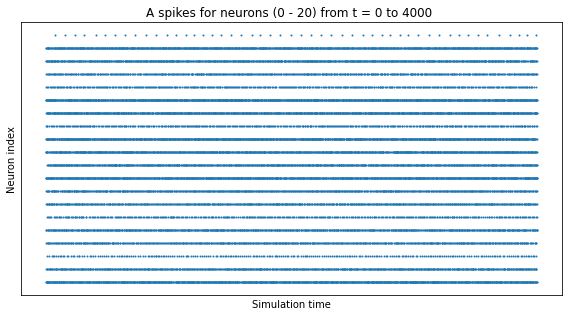

<Figure size 432x288 with 0 Axes>

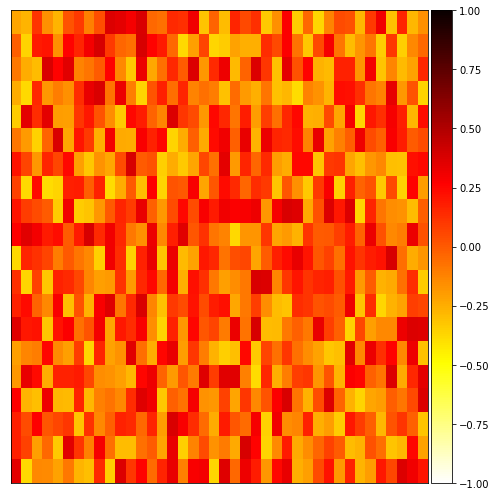

<Figure size 432x288 with 0 Axes>

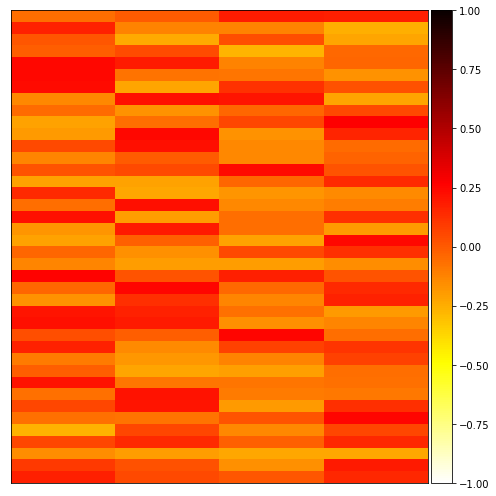

In [80]:
#create input spike data, where each spike is distributed according bernoulli
#input_data = torch.bernoulli(0.1 * torch.ones(time, source_layer.n)).byte()
#inputs = {"A":input_data}
spike_rate = 350 #maximum spike rate in hz

input_rates = spike_rate * torch.rand(source_layer.n)  # Generate random Poisson rates for N input neurons.
input_data= encoding.poisson(datum=input_rates, time=time * batch)  # Encode input as time ms Poisson spike trains.
inputs = {"A":input_data}

vary = torch.randint(low=0,high=target_layer.n,size=[batch])
if batch == 1:
    y = torch.tensor([0, 1, 0, 0],dtype=torch.uint8) #target label
else:
    y = torch.nn.functional.one_hot(vary)

print("Target labels ",y)

#plot the input train spike
plt.ioff()
plt.figure()
plot_spikes(inputs)
plt.show()
plt.figure()
plot_weights(forward_connection1.w,wmin=-1,figsize=[7,7])
plt.figure()
plot_weights(forward_connection2.w,wmin=-1,figsize=[7,7])


In [81]:
#begin the training procedure

#loop for 150 epochs
epochs = 50
L = torch.zeros(epochs) #store in the vector
l = torch.zeros(batch)
plot_train = False

for i in range(epochs): #loop for each epoch 
    for j in range(batch): #loop for each training sample in a batch
        #1. run forward propagation 
        inputs = {"A":input_data[j*time:(j*time)+time,:]}
        network.run(inputs=inputs,time=time)
        #1.1 obtain the spike activity in each nodes of every layer
        #x -> 
        spikes = {
        "A" : source_monitor.get("s"),
        "B" : hidden_monitor.get("s"),
        "C" : target_monitor.get("s")
        }

        voltages = {"B": hidden_monitor.get("v"),
                    "C": target_monitor.get("v")
        }

        
        #plot the spikes and voltages
        
        if plot_train:
            plt.ioff()
            plt.figure()
            plot_spikes(spikes)
            plt.figure()
            plot_voltages(voltages, plot_type="line")
            plt.show()
        #end of the plots
        
        a_hidden = spikes["B"].squeeze().float() #get the spike activity at the hidden layer
        a_out    = spikes["C"].squeeze().float() #get the spike activity at the output layer   
        
        print(torch.sum(a_out,dim=0)) #print the spike's output activity
        #print(torch.sum(a_hidden,dim=0)) #print the spike's hidden activity

        x_hidden = input_data
        x_out    = a_hidden

        #2. calculate and keep track the loss
        l[j] = loss_output(y[j],a_out)       #y[j,:] 
        
        #3.propagate the error backprop

        delta_i_out    =  error_backprop_out(y[j],a_out)#y[j,:]
        delta_i_hid    =  error_backprop(network,a_hidden,a_out,delta_i_out)    
        #print the delta i
        #print(delta_i_out)
        #print(delta_i_hid)
        
        #4.update the paramaters (weight & threshold)
        update_params(network,eta_w,eta_th,delta_i_out,delta_i_hid,a_out,a_hidden,x_out,x_hidden)
        #print the weight
        #print(forward_connection2.w)
        #print(network.layers["B"].thresh)

        #5.reset the membrane potential in the network
        network.layers["C"].reset_state_variables()
        network.layers["B"].reset_state_variables()

        #print(network.layers["C"].thresh)
        #print(network.layers["B"].v)        
        
    #print(network.layers["C"].thresh)
    #print(network.layers["B"].thresh)
    

    L[i] = torch.sum(l)
    print("vector l",l)
    print("epochs , loss : ",i,L[i])
    if L[i] < 0.1: #if the loss is less than specified number
            break #stop the loop



tensor([35.,  0.,  0.,  0.])
tensor([219.,   0.,   0.,   0.])
tensor([394.,   4.,   0.,   0.])
tensor([394.,  20.,   0., 133.])
tensor([394., 234.,   0., 156.])
tensor([394., 374., 213., 156.])
tensor([394., 374., 422., 156.])
tensor([394., 374., 422., 156.])
vector l tensor([1.0000, 1.0000, 1.0001, 1.0075, 1.2547, 1.1344, 0.9633, 0.8969])
epochs , loss :  0 tensor(8.2569)
tensor([359., 374., 422., 156.])
tensor([175., 411., 422., 195.])
tensor([  0., 428., 422., 220.])
tensor([  0., 412., 428., 113.])
tensor([  0., 201., 455.,  97.])
tensor([  0.,  61., 261., 102.])
tensor([  0.,  61.,  60., 102.])
tensor([  0.,  87., 111., 102.])
vector l tensor([1.4532, 0.6931, 1.1042, 0.5356, 0.1203, 0.1037, 1.3518, 0.7294])
epochs , loss :  1 tensor(6.0912)
tensor([  0.,  99., 156., 102.])
tensor([  0.,  62., 156.,  63.])
tensor([  0.,  97., 156.,  38.])
tensor([  0.,  97., 150.,  48.])
tensor([  0., 131., 123.,  41.])
tensor([  0., 131., 104.,  36.])
tensor([  0., 131.,  96.,  36.])
tensor([  0.,

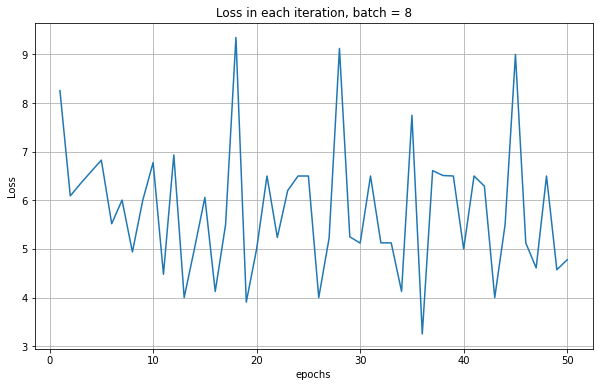

In [82]:
x_ax = np.linspace(1,len(L),len(L))
plt.figure(figsize=[10,6])
plt.plot(x_ax,L)
plt.title("Loss in each iteration, batch = %s"%batch)
#plt.text(0.5,1.5,'batch size = %s'%batch)
plt.ylabel("Loss",)
plt.xlabel("epochs")
plt.grid(True)

In [83]:
print(L)
print("spike activity at the output layer",torch.sum(a_out,dim=0))
print("target label",y)
#print(network.layers["B"].thresh)
#print(network.layers["C"].thresh)
#print(delta_i_out)
#print(delta_i_hid)
#print(loss_output(y[6,:],a_out))
#print(network.layers["C"].thresh)


tensor([8.2569, 6.0912, 6.3471, 6.5886, 6.8256, 5.5182, 6.0047, 4.9375, 6.0000,
        6.7766, 4.4776, 6.9337, 4.0000, 5.0115, 6.0598, 4.1252, 5.5000, 9.3493,
        3.9061, 5.0000, 6.5000, 5.2364, 6.2007, 6.5000, 6.5000, 4.0000, 5.2228,
        9.1240, 5.2500, 5.1200, 6.5000, 5.1255, 5.1245, 4.1250, 7.7490, 3.2508,
        6.6108, 6.5099, 6.5000, 5.0000, 6.5000, 6.2923, 4.0000, 5.5000, 9.0000,
        5.1235, 4.6098, 6.5000, 4.5716, 4.7781])
spike activity at the output layer tensor([0., 0., 0., 0.])
target label tensor([[0, 0, 0, 1],
        [0, 1, 0, 0],
        [0, 0, 0, 1],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 1, 0],
        [1, 0, 0, 0],
        [0, 0, 1, 0]])


<Figure size 432x288 with 0 Axes>

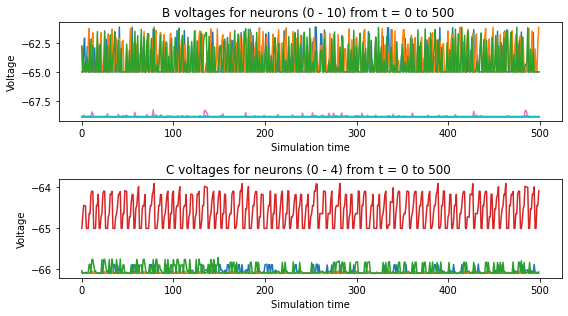

membrane voltage value before reset
tensor([[-65.0000, -61.1780, -65.0000, -68.8730, -68.8730, -68.8730, -68.8730,
         -68.8730, -68.8730, -68.8730]])
tensor([[-66.0954, -66.0954, -66.0612, -64.0859]])


In [106]:
#plot the voltage 
plt.figure()
plot_voltages(voltages, plot_type="line")
plt.show()
print("membrane voltage value before reset")
print(network.layers["B"].v)
print(network.layers["C"].v)